# LOADING LIBS AND MODULES

In [1]:
# core
import numpy as np
import pandas as pd
import datetime as dt
import yaml
import pickle

# explainability
# import shap

# modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# models
from xgboost import XGBRegressor

# otm
import optuna

# our functions
import utils_gpu

import warnings
warnings.filterwarnings('ignore')

c:\Users\yuric\OneDrive\Área de Trabalho\HACKATON\CP007--Hackathon-Forecast-2025--Big-Data\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LOADING THE PARAMETER CONFIGURATION FILE

In [2]:
# loading up the YAML dictionary that contains all the parameters for the model
with open("model_params.yml", "r") as f:
    configs = yaml.safe_load(f)

# SETTING UP DEFAULTS AND PARAMETERS

In [3]:
# showing all columns in a pandas dataframe
pd.options.display.max_columns = None

# extracting the keys associated with the parameters
RANDOM_STATE = configs['RANDOM_STATE']
NUMBER_OF_FOLDS = configs['NUMBER_OF_FOLDS']
STRATIFICATION = configs['STRATIFICATION']
FEATURE_STRATIFICATION = configs['FEATURE_STRATIFICATION']
EVAL_FEATURES = configs['EVAL_FEATURES']

FEATURE_COLUMNS = configs['FEATURES']
LABEL_COLUMNS = configs['TARGET']

PREPROCESSING = configs['PREPROCESSING']

# OPTUNA AND MODEL PARAMS
OPTUNA_PARAMS = configs['OPTUNA_PARAMS']
MODEL_RANGE_PARAMS = OPTUNA_PARAMS['MODEL']

# SHAP PARAMS
SHAP_PARMS = configs['SHAP_PARAMS']
SHAP_SAMPLE = SHAP_PARMS['SHAP_SAMPLE']

# LOADING THE DATA

### Transaction Dataset

In [4]:
print("Loading the dataset containing the training data for the demand forecasting model.")
df = pd.read_parquet('../../data/processed/processed_data.parquet')
df['week_of_year'] = df['week_of_year'].astype(int)
df = df.sort_values(["week_of_year", "internal_product_id", "internal_store_id"]).reset_index(drop=True)
df['ID_LOG'] = range(len(df))
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Loading the dataset containing the training data for the demand forecasting model.
The dataset contains 5928381 rows and 29 columns.


### Pre-processing input data

#### Analyzing some features

In [5]:
# We note that these rows with None premise represents PDVs with no id in store dataset.
df[(pd.isna(df['premise'])) & (df.quantity > 0)].head(3)

,internal_product_id,internal_store_id,distributor_id,premise,categoria_pdv,zipcode,tipos,label,subcategoria,marca,fabricante,month,week_of_year,city,quantity,holiday,previous_month_quantity_sum,previous_month_gross_value_sum,previous_month_net_value_sum,previous_month_gross_profit_sum,previous_month_discount_sum,quantity_lag1,quantity_lag2,quantity_lag3,quantity_lag4,quantity_lag5,discount_rate_month,profit_margin_month,ID_LOG
4026397,1471722963249789482,2358311751739790587,6,None,None,NaN,Distilled Spirits,None,Vodka,Skol Premium Vodka,Sazerac Spirits,9,37,None,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4026397
4026416,1471722963249789482,3042159963835101491,6,None,None,NaN,Distilled Spirits,None,Vodka,Skol Premium Vodka,Sazerac Spirits,9,37,None,24,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4026416
4026417,1471722963249789482,3064081542928238118,6,None,None,NaN,Distilled Spirits,None,Vodka,Skol Premium Vodka,Sazerac Spirits,9,37,None,60,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4026417


In [6]:
# This represents 35455 rows of the dataset. The problem is that this negatively impacts the features,
# since we won't have categorical POS information, and as if that weren't enough, sales only occur in
# 62 rows. Consequently, the features created with "previous" terms mostly have NaN values, leaving the
# dataset very sparse and not helping the model learn. Therefore, we will drop these 35455, which
# represent only 0.6% of the original database.
no_store = len(df[pd.isna(df['premise'])])
no_store_with_quantity = len(df[(pd.isna(df['premise'])) & (df.quantity > 0)])
print(f"{no_store} rows are not in the store dataset.")
print(f"Of these {no_store} lines, only in {no_store_with_quantity} we have number of sales greater than zero.")
print(f"Representing proportionally {100*no_store/df.shape[0]:.3f}% and {100*no_store_with_quantity/df.shape[0]:.3f}% of the transaction dataset.")

# Dropping these lines
df = df[~ pd.isna(df['premise'])]

35455 rows are not in the store dataset.
Of these 35455 lines, only in 62 we have number of sales greater than zero.
Representing proportionally 0.598% and 0.001% of the transaction dataset.


#### Transforming premise in a binary feature

In [7]:
# Transformation
df['premise'] = df['premise'].map({'Off Premise': 1, 'On Premise': 0}).astype(int)

#### Fill NaN values in "_sum" columns

In [8]:
# Fill NaN values in "_sum" columns
cols_sum = df.columns[df.columns.str.contains("sum")]
df[cols_sum] = df[cols_sum].fillna(0)

### Understanding the behaviour of seasonality

In [9]:
# df.groupby("label").internal_product_id.count()


In [10]:
# import plotly.express as px

# tmp = df[df.label.isna()]

# # Agrupar os dados por week_of_year e tipo, e somar as quantidades
# df_grouped = tmp.groupby(['month', 'tipos'])['quantity'].sum().reset_index()

# # Plotar o gráfico interativo com Plotly
# fig = px.line(df_grouped, 
#               x='month', 
#               y='quantity', 
#               color='tipos', 
#               title='Sazonalidade da Quantidade por Tipo de Produto',
#               labels={'month': 'Mês do Ano', 'quantity': 'Quantidade'},
#               markers=True)

# # Personalizar a aparência do gráfico
# fig.update_layout(
#     xaxis_title='Mês do Ano',
#     yaxis_title='Quantidade',
#     legend_title='Tipos de Produto',
#     showlegend=True,
#     template='plotly_white'
# )

# # Exibir o gráfico
# fig.show()

In [11]:
# dropping label 'other'
df = df[~(df.label == 'Other')].reset_index(drop=True)

# renaming label Specialty to Speciality (merge theses two labels)
df['label'] = df['label'].replace({'Specialty': 'Speciality'})

df[(df.tipos == 'Allocated Spirits') & (df.subcategoria == 'Liqueurs & Cordials')]['label'] = 'Discontinued'

# SEPARATING THE FEATURES BY TYPE

In [12]:
# mapping which columns should be treated as numerical columns - excluding cyclical features
NUMERIC_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes(np.number).columns if column not in PREPROCESSING['CYCLICAL_FEATURES'].keys()]
# mapping which columns should be treated as categorical columns
CATEGORICAL_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes('object').columns]

# SPLITTING THE DATA

### Mapping which instances should be placed in the train and test splits

In [13]:
# splitting the data into training and testing sets
# training set: all data before December 2022
X_train = df.loc[df.month != 12, :]
y_train = df.loc[df.month != 12, :]
# test set: all data from December 2022 onwards
X_test = df.loc[df.month == 12, :]
y_test = df.loc[df.month == 12, :]

### Creating the cross validation folds

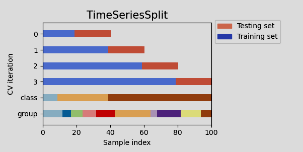

In [14]:
# creating the stratified k fold instance
tscv = TimeSeriesSplit(n_splits=NUMBER_OF_FOLDS)

## TRAINING WITH CROSS VALIDATION

### OTM Hyperparams Optuna

In [15]:
def defining_hyperparams(trial, hyperparam_ranges):
    v1 = trial.suggest_int('max_depth', hyperparam_ranges['max_depth'][0], hyperparam_ranges['max_depth'][1], log=hyperparam_ranges['max_depth'][2])
    v2 = trial.suggest_int('n_estimators', hyperparam_ranges['n_estimators'][0], hyperparam_ranges['n_estimators'][1], log=hyperparam_ranges['n_estimators'][2])
    v3 = trial.suggest_float('learning_rate', hyperparam_ranges['learning_rate'][0], hyperparam_ranges['learning_rate'][1], log=hyperparam_ranges['learning_rate'][2])
    v4 = trial.suggest_float('reg_alpha', hyperparam_ranges['reg_alpha'][0], hyperparam_ranges['reg_alpha'][1], log=hyperparam_ranges['reg_alpha'][2])
    v5 = trial.suggest_float('reg_lambda', hyperparam_ranges['reg_lambda'][0], hyperparam_ranges['reg_lambda'][1], log=hyperparam_ranges['reg_lambda'][2])
    v6 = trial.suggest_float('min_child_weight', hyperparam_ranges['min_child_weight'][0], hyperparam_ranges['min_child_weight'][1], log=hyperparam_ranges['min_child_weight'][2])
    v7 = trial.suggest_float('subsample', hyperparam_ranges['subsample'][0], hyperparam_ranges['subsample'][1], log=hyperparam_ranges['subsample'][2])
    v8 = trial.suggest_float('colsample_bytree', hyperparam_ranges['colsample_bytree'][0], hyperparam_ranges['colsample_bytree'][1], log=hyperparam_ranges['colsample_bytree'][2])
    v9 = trial.suggest_categorical('tweedie_variance_power', hyperparam_ranges['tweedie_variance_power'][0])
    return {'max_depth':v1, 'n_estimators':v2, 'learning_rate':v3, 'reg_alpha':v4, 'reg_lambda':v5,
            'min_child_weight':v6, 'subsample':v7, 'colsample_bytree':v8, 'tweedie_variance_power':v9}

In [16]:
# Configuring and execute the study
study = optuna.create_study(study_name='best_model', direction=OPTUNA_PARAMS['DIRECTION'])
study.set_metric_names(["score_validation"])

study.optimize(utils_gpu.create_objective_function(hyperparam_ranges        = MODEL_RANGE_PARAMS,
                                            tscv                            = tscv,
                                            x_data                          = [X_train,y_train],
                                            regressor_model                 = XGBRegressor,
                                            columns_to_use                  = [FEATURE_COLUMNS, LABEL_COLUMNS, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS],
                                            eval_features                   = EVAL_FEATURES,
                                            preprocessing                   = PREPROCESSING,
                                            random_state                    = RANDOM_STATE,
                                            defining_hyperparams_function   = defining_hyperparams,
                                            multi_scores                    = False),
                                            n_trials                        = OPTUNA_PARAMS['TRIALS']
)

[I 2025-09-22 19:50:03,341] A new study created in memory with name: best_model


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 16.78s
[Fold 1] Predict finished.
[Fold 1] Tempo: 35.90s
[Fold 1] SMAPE Training:   42.78506438043531.
[Fold 1] SMAPE Validation: 35.25414021521966.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 31.76s
[Fold 2] Predict finished.
[Fold 2] Tempo: 60.38s
[Fold 2] SMAPE Training:   38.56121043739743.
[Fold 2] SMAPE Validation: 34.51358281983284.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 47.23s
[Fold 3] Predict finished.
[Fold 3] Tempo: 84.49s
[Fold 3] SMAPE Training:   37.06394766621925.
[Fold 3] SMAPE Validation: 33.51289147136524.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating the 

[I 2025-09-22 19:57:25,723] Trial 0 finished with value: {'score_validation': 34.784239260239914} and parameters: {'max_depth': 6, 'n_estimators': 704, 'learning_rate': 0.026121215821840803, 'reg_alpha': 0.01756045085560519, 'reg_lambda': 0.048358034069839226, 'min_child_weight': 2.0707132088943236, 'subsample': 0.8576094542207134, 'colsample_bytree': 0.5099107455338125, 'tweedie_variance_power': 1.6}. Best is trial 0 with value: 34.784239260239914.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 14.62s
[Fold 1] Predict finished.
[Fold 1] Tempo: 33.55s
[Fold 1] SMAPE Training:   43.360347962426566.
[Fold 1] SMAPE Validation: 35.73301166658426.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 28.17s
[Fold 2] Predict finished.
[Fold 2] Tempo: 56.03s
[Fold 2] SMAPE Training:   38.949180729703436.
[Fold 2] SMAPE Validation: 34.600309552782875.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 41.23s
[Fold 3] Predict finished.
[Fold 3] Tempo: 78.14s
[Fold 3] SMAPE Training:   37.33326599494909.
[Fold 3] SMAPE Validation: 33.699297670423356.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating 

[I 2025-09-22 20:04:21,040] Trial 1 finished with value: {'score_validation': 34.99439427061964} and parameters: {'max_depth': 5, 'n_estimators': 493, 'learning_rate': 0.035257762284756695, 'reg_alpha': 0.079945651343972, 'reg_lambda': 0.07481650689602673, 'min_child_weight': 2.32824394001708, 'subsample': 0.7827272385574734, 'colsample_bytree': 0.6035977513424036, 'tweedie_variance_power': 1.7}. Best is trial 0 with value: 34.784239260239914.


[Fold 5] SMAPE Training:   35.95772316726165.
[Fold 5] SMAPE Validation: 36.32152792546003.
[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 32.68s
[Fold 1] Predict finished.
[Fold 1] Tempo: 51.71s
[Fold 1] SMAPE Training:   39.61363816466808.
[Fold 1] SMAPE Validation: 34.273150034918416.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 54.22s
[Fold 2] Predict finished.
[Fold 2] Tempo: 83.11s
[Fold 2] SMAPE Training:   36.22732556109177.
[Fold 2] SMAPE Validation: 34.365418309009456.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 75.42s
[Fold 3] Predict finished.
[Fold 3] Tempo: 113.27s
[Fold 3] SMAPE Training:   35.2344313630457.
[Fold 3] SMAPE

[I 2025-09-22 20:14:08,331] Trial 2 finished with value: {'score_validation': 34.19321887011139} and parameters: {'max_depth': 9, 'n_estimators': 1470, 'learning_rate': 0.025852571983919954, 'reg_alpha': 3.9826802681031026, 'reg_lambda': 0.9697659756509254, 'min_child_weight': 1.6169087119898102, 'subsample': 0.6793017968109398, 'colsample_bytree': 0.6365304861685804, 'tweedie_variance_power': 1.4}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 15.94s
[Fold 1] Predict finished.
[Fold 1] Tempo: 34.57s
[Fold 1] SMAPE Training:   40.60810237926524.
[Fold 1] SMAPE Validation: 34.75689483715212.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 29.43s
[Fold 2] Predict finished.
[Fold 2] Tempo: 57.06s
[Fold 2] SMAPE Training:   36.978985119956945.
[Fold 2] SMAPE Validation: 35.03401129410318.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 42.81s
[Fold 3] Predict finished.
[Fold 3] Tempo: 79.94s
[Fold 3] SMAPE Training:   35.84346761560166.
[Fold 3] SMAPE Validation: 33.19181586257975.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating the

[I 2025-09-22 20:21:11,496] Trial 3 finished with value: {'score_validation': 34.74829749965496} and parameters: {'max_depth': 8, 'n_estimators': 416, 'learning_rate': 0.07025735897292837, 'reg_alpha': 0.0011093533274373697, 'reg_lambda': 0.31476268851640565, 'min_child_weight': 6.666829764202927, 'subsample': 0.9028448318914544, 'colsample_bytree': 0.9035887964520718, 'tweedie_variance_power': 1.9}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 45.38s
[Fold 1] Predict finished.
[Fold 1] Tempo: 64.95s
[Fold 1] SMAPE Training:   38.08928691309671.
[Fold 1] SMAPE Validation: 34.74207741077156.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 76.79s
[Fold 2] Predict finished.
[Fold 2] Tempo: 106.00s
[Fold 2] SMAPE Training:   34.90829508027143.
[Fold 2] SMAPE Validation: 37.554265655125704.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 105.88s
[Fold 3] Predict finished.
[Fold 3] Tempo: 144.78s
[Fold 3] SMAPE Training:   34.14478217879048.
[Fold 3] SMAPE Validation: 33.20701973593266.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating 

[I 2025-09-22 20:33:32,652] Trial 4 finished with value: {'score_validation': 35.49485797176962} and parameters: {'max_depth': 8, 'n_estimators': 3091, 'learning_rate': 0.07600144322844093, 'reg_alpha': 0.00839908618394925, 'reg_lambda': 0.09120072123902781, 'min_child_weight': 1.8874589210441466, 'subsample': 0.6795863259379055, 'colsample_bytree': 0.9934778476189814, 'tweedie_variance_power': 1.3}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 38.21s
[Fold 1] Predict finished.
[Fold 1] Tempo: 57.54s
[Fold 1] SMAPE Training:   37.10531387674825.
[Fold 1] SMAPE Validation: 34.34822109565836.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 61.43s
[Fold 2] Predict finished.
[Fold 2] Tempo: 90.16s
[Fold 2] SMAPE Training:   34.262135873299115.
[Fold 2] SMAPE Validation: 35.10499907220446.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 84.69s
[Fold 3] Predict finished.
[Fold 3] Tempo: 123.39s
[Fold 3] SMAPE Training:   33.58346169155645.
[Fold 3] SMAPE Validation: 32.76294657464374.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating th

[I 2025-09-22 20:44:09,081] Trial 5 finished with value: {'score_validation': 34.642921465947666} and parameters: {'max_depth': 9, 'n_estimators': 1928, 'learning_rate': 0.08220598019480951, 'reg_alpha': 9.22004720712243, 'reg_lambda': 0.00838813693418948, 'min_child_weight': 24.16935335141497, 'subsample': 0.9632390036282623, 'colsample_bytree': 0.5624044975635696, 'tweedie_variance_power': 1.6}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 30.26s
[Fold 1] Predict finished.
[Fold 1] Tempo: 49.44s
[Fold 1] SMAPE Training:   41.26158188182867.
[Fold 1] SMAPE Validation: 34.84162079796075.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 54.10s
[Fold 2] Predict finished.
[Fold 2] Tempo: 82.91s
[Fold 2] SMAPE Training:   37.40713420381972.
[Fold 2] SMAPE Validation: 35.3664833625207.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 77.40s
[Fold 3] Predict finished.
[Fold 3] Tempo: 115.53s
[Fold 3] SMAPE Training:   36.26955490520787.
[Fold 3] SMAPE Validation: 32.75032165464874.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating the 

[I 2025-09-22 20:54:07,507] Trial 6 finished with value: {'score_validation': 34.66146368687943} and parameters: {'max_depth': 6, 'n_estimators': 2494, 'learning_rate': 0.031360710633420795, 'reg_alpha': 4.011476322734464, 'reg_lambda': 0.08510015492059127, 'min_child_weight': 12.924774991933347, 'subsample': 0.5279979597607127, 'colsample_bytree': 0.8249282081122958, 'tweedie_variance_power': 1.8}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 35.18s
[Fold 1] Predict finished.
[Fold 1] Tempo: 54.35s
[Fold 1] SMAPE Training:   38.5201399096071.
[Fold 1] SMAPE Validation: 34.41582400989029.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 57.52s
[Fold 2] Predict finished.
[Fold 2] Tempo: 86.02s
[Fold 2] SMAPE Training:   35.426817641982986.
[Fold 2] SMAPE Validation: 35.044446672517395.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 79.70s
[Fold 3] Predict finished.
[Fold 3] Tempo: 117.57s
[Fold 3] SMAPE Training:   34.57634179799239.
[Fold 3] SMAPE Validation: 32.93395090415031.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating th

[I 2025-09-22 21:04:17,582] Trial 7 finished with value: {'score_validation': 34.76712754609299} and parameters: {'max_depth': 9, 'n_estimators': 1667, 'learning_rate': 0.04318908892811042, 'reg_alpha': 0.0038223296702186433, 'reg_lambda': 4.565193714985828, 'min_child_weight': 10.852204844963381, 'subsample': 0.8038455608188466, 'colsample_bytree': 0.585945147215739, 'tweedie_variance_power': 1.9}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 48.02s
[Fold 1] Predict finished.
[Fold 1] Tempo: 67.73s
[Fold 1] SMAPE Training:   36.75465224971614.
[Fold 1] SMAPE Validation: 34.2430237132236.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 76.01s
[Fold 2] Predict finished.
[Fold 2] Tempo: 105.28s
[Fold 2] SMAPE Training:   34.19901547519628.
[Fold 2] SMAPE Validation: 35.76159260948993.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 103.01s
[Fold 3] Predict finished.
[Fold 3] Tempo: 141.36s
[Fold 3] SMAPE Training:   33.552049207690146.
[Fold 3] SMAPE Validation: 32.86743620860702.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating t

[I 2025-09-22 21:16:29,122] Trial 8 finished with value: {'score_validation': 34.97431799642587} and parameters: {'max_depth': 9, 'n_estimators': 2610, 'learning_rate': 0.052090323800363235, 'reg_alpha': 0.0011063042416378508, 'reg_lambda': 1.2530190511547343, 'min_child_weight': 3.317014265338099, 'subsample': 0.9414809503929205, 'colsample_bytree': 0.5998017582540337, 'tweedie_variance_power': 1.8}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 20.45s
[Fold 1] Predict finished.
[Fold 1] Tempo: 39.47s
[Fold 1] SMAPE Training:   39.99383470573542.
[Fold 1] SMAPE Validation: 34.63506704319859.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 36.00s
[Fold 2] Predict finished.
[Fold 2] Tempo: 64.18s
[Fold 2] SMAPE Training:   36.603066462229336.
[Fold 2] SMAPE Validation: 34.650943051011026.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 51.29s
[Fold 3] Predict finished.
[Fold 3] Tempo: 88.73s
[Fold 3] SMAPE Training:   35.53228213399834.
[Fold 3] SMAPE Validation: 32.64193800751411.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating th

[I 2025-09-22 21:24:15,669] Trial 9 finished with value: {'score_validation': 34.47620357494616} and parameters: {'max_depth': 9, 'n_estimators': 620, 'learning_rate': 0.05985212364327329, 'reg_alpha': 7.906082881668493, 'reg_lambda': 0.0024355347484534056, 'min_child_weight': 1.2851157909481157, 'subsample': 0.5771186522246272, 'colsample_bytree': 0.5205981479042782, 'tweedie_variance_power': 1.3}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 20.87s
[Fold 1] Predict finished.
[Fold 1] Tempo: 39.71s
[Fold 1] SMAPE Training:   41.77873451555957.
[Fold 1] SMAPE Validation: 34.79399144813877.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 37.57s
[Fold 2] Predict finished.
[Fold 2] Tempo: 65.52s
[Fold 2] SMAPE Training:   37.837546901980126.
[Fold 2] SMAPE Validation: 34.451247749513755.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 54.81s
[Fold 3] Predict finished.
[Fold 3] Tempo: 92.50s
[Fold 3] SMAPE Training:   36.50340045975741.
[Fold 3] SMAPE Validation: 32.92440626993695.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating th

[I 2025-09-22 21:32:18,592] Trial 10 finished with value: {'score_validation': 34.427791885859584} and parameters: {'max_depth': 7, 'n_estimators': 1040, 'learning_rate': 0.020315651912783783, 'reg_alpha': 1.0274247748831047, 'reg_lambda': 7.841990273831829, 'min_child_weight': 1.0578188835413833, 'subsample': 0.649397209523823, 'colsample_bytree': 0.7101609548288436, 'tweedie_variance_power': 1.4}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 19.72s
[Fold 1] Predict finished.
[Fold 1] Tempo: 38.74s
[Fold 1] SMAPE Training:   41.85042629432155.
[Fold 1] SMAPE Validation: 34.779131083158205.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 36.01s
[Fold 2] Predict finished.
[Fold 2] Tempo: 64.00s
[Fold 2] SMAPE Training:   37.89810770871366.
[Fold 2] SMAPE Validation: 34.4784709163836.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 51.87s
[Fold 3] Predict finished.
[Fold 3] Tempo: 89.32s
[Fold 3] SMAPE Training:   36.5667712591462.
[Fold 3] SMAPE Validation: 33.19253033789336.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating the p

[I 2025-09-22 21:40:09,009] Trial 11 finished with value: {'score_validation': 34.50650232232433} and parameters: {'max_depth': 7, 'n_estimators': 911, 'learning_rate': 0.02115763341691341, 'reg_alpha': 0.8535283449500515, 'reg_lambda': 9.599111441156897, 'min_child_weight': 1.01407816577339, 'subsample': 0.6661826152832919, 'colsample_bytree': 0.7127554379276938, 'tweedie_variance_power': 1.4}. Best is trial 2 with value: 34.19321887011139.


[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 22.04s
[Fold 1] Predict finished.
[Fold 1] Tempo: 40.84s
[Fold 1] SMAPE Training:   41.564134555873125.
[Fold 1] SMAPE Validation: 34.64296356688339.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 39.42s
[Fold 2] Predict finished.
[Fold 2] Tempo: 67.89s
[Fold 2] SMAPE Training:   37.700747037430965.
[Fold 2] SMAPE Validation: 34.54504108610916.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 57.50s
[Fold 3] Predict finished.
[Fold 3] Tempo: 95.50s
[Fold 3] SMAPE Training:   36.441693717494964.
[Fold 3] SMAPE Validation: 33.01260013922717.
[Fold 4] Training fold: 3581958 samples
[Fold 4] Creating t

[I 2025-09-22 21:48:27,300] Trial 12 finished with value: {'score_validation': 34.45877711666026} and parameters: {'max_depth': 7, 'n_estimators': 1175, 'learning_rate': 0.02095656530708832, 'reg_alpha': 0.703509090526764, 'reg_lambda': 1.3192114304874372, 'min_child_weight': 4.4312315565967575, 'subsample': 0.6210179618024119, 'colsample_bytree': 0.7131107991031835, 'tweedie_variance_power': 1.4}. Best is trial 2 with value: 34.19321887011139.


[Fold 5] SMAPE Training:   35.195005978137154.
[Fold 5] SMAPE Validation: 35.84555974002931.
[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 35.89s
[Fold 1] Predict finished.
[Fold 1] Tempo: 55.04s
[Fold 1] SMAPE Training:   38.69864717227349.
[Fold 1] SMAPE Validation: 34.19248337399145.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] Fit finished in 57.22s
[Fold 2] Predict finished.
[Fold 2] Tempo: 85.76s
[Fold 2] SMAPE Training:   35.59162276851975.
[Fold 2] SMAPE Validation: 34.43905716512176.
[Fold 3] Training fold: 2686469 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] Fit finished in 79.06s
[Fold 3] Predict finished.
[Fold 3] Tempo: 118.63s
[Fold 3] SMAPE Training:   34.69839827265346.
[Fold 3] SMAPE

[I 2025-09-22 21:58:44,915] Trial 13 finished with value: {'score_validation': 34.20816957734846} and parameters: {'max_depth': 10, 'n_estimators': 1252, 'learning_rate': 0.02609288679466356, 'reg_alpha': 0.992225600431656, 'reg_lambda': 1.474208905784783, 'min_child_weight': 1.3668753812402203, 'subsample': 0.7314425653228342, 'colsample_bytree': 0.6814601383619784, 'tweedie_variance_power': 1.5}. Best is trial 2 with value: 34.19321887011139.


[Fold 5] SMAPE Training:   33.80308215212594.
[Fold 5] SMAPE Validation: 36.26151463612562.
[Fold 1] Training fold: 895491 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] Fit finished in 44.48s
[Fold 1] Predict finished.
[Fold 1] Tempo: 64.07s
[Fold 1] SMAPE Training:   37.937541811090746.
[Fold 1] SMAPE Validation: 34.24039088839124.
[Fold 2] Training fold: 1790980 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.


[W 2025-09-22 22:00:10,972] Trial 14 failed with parameters: {'max_depth': 10, 'n_estimators': 1643, 'learning_rate': 0.028426278447030887, 'reg_alpha': 0.23454703922274778, 'reg_lambda': 0.7203701421233052, 'min_child_weight': 3.132613200899199, 'subsample': 0.7415460263899253, 'colsample_bytree': 0.7944203352984869, 'tweedie_variance_power': 1.5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\yuric\OneDrive\Área de Trabalho\HACKATON\CP007--Hackathon-Forecast-2025--Big-Data\.venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\yuric\OneDrive\Área de Trabalho\HACKATON\CP007--Hackathon-Forecast-2025--Big-Data\notebooks\02_models\utils_gpu.py", line 259, in <lambda>
    return lambda trial: objective(trial, hyperparam_ranges, tscv, x_data, regressor_model, columns_to_use, eval_features,
  File "c:\Users\yuric\OneDrive\Área de Trabalho\HACKATON\CP007--Hackatho

KeyboardInterrupt: 

In [30]:
# saving best params of otm optuna into variable
_, best_params = utils_gpu.get_best_params(study)
# best_params = {'max_depth': 9, 'n_estimators': 1470, 'learning_rate': 0.025852571983919954, 'reg_alpha': 3.9826802681031026, 'reg_lambda': 0.9697659756509254, 'min_child_weight': 1.6169087119898102, 'subsample': 0.6793017968109398, 'colsample_bytree': 0.6365304861685804, 'tweedie_variance_power': 1.4}
best_params = {'max_depth': 10, 'n_estimators': 1252, 'learning_rate': 0.02609288679466356, 'reg_alpha': 0.992225600431656, 'reg_lambda': 1.474208905784783, 'min_child_weight': 1.3668753812402203, 'subsample': 0.7314425653228342, 'colsample_bytree': 0.6814601383619784, 'tweedie_variance_power': 1.5}
best_params['objective'] = "reg:tweedie"
print(best_params)

{'max_depth': 10, 'n_estimators': 1252, 'learning_rate': 0.02609288679466356, 'reg_alpha': 0.992225600431656, 'reg_lambda': 1.474208905784783, 'min_child_weight': 1.3668753812402203, 'subsample': 0.7314425653228342, 'colsample_bytree': 0.6814601383619784, 'tweedie_variance_power': 1.5, 'objective': 'reg:tweedie'}


## FITTING THE MODEL TO EVALUATE

### Re-creating the pre-processing pipeline

In [31]:
pipe_preproc = utils_gpu.create_preprocessing_pipeline(preprocessing_configs=PREPROCESSING, numeric_columns=NUMERIC_COLUMNS, categorical_columns=CATEGORICAL_COLUMNS)

### Fitting the model  to the training data

In [22]:
# calculatin weights
tipo_freq = X_train['tipos'].value_counts(normalize=True)
weight_tipo = X_train['tipos'].map(lambda x: 1 / tipo_freq[x])
weight_label = np.where(X_train['label'] == 'Winter Seasonal', 1.2, 1.0)
sample_weight = weight_tipo * weight_label

In [32]:
# regressor model
base_regressor = XGBRegressor(**best_params,
                                random_state=RANDOM_STATE,
                                device='cuda',
                                tree_method='hist')

# transformed target and pack with regressor
ttr = TransformedTargetRegressor(
    regressor=base_regressor,
    func=np.log1p,      # transforma y -> log(1+y) no fit
    inverse_func=np.expm1  # volta para o espaço original no predict
)

# creating a pipeline object to accomodate both: pre-processing steps and the model
pipeline = Pipeline(steps=[
    ('preprocessing', pipe_preproc),
    ('model', ttr),
])

# training the model
pipeline.fit(X_train.loc[:, FEATURE_COLUMNS], y_train.loc[:, LABEL_COLUMNS].values.ravel(), **{'model__sample_weight': sample_weight})

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('target_encoding', ...), ('cyclical_features', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('impute', ...), ('clean', ...), ...]"
,transform_input,None
,memory,None


### Evaluating model performance

In [33]:
import xgboost as xgb

# Reconstituir dataframes de avaliação
train = df.loc[X_train.index].copy()
test  = df.loc[X_test.index].copy()

# predicting the target values for the training and validation folds
booster = pipeline.named_steps['model'].regressor_.get_booster()

# transforme usando o preprocessing (mantém DataFrame com colunas) - training set
Xv_proc = pipeline.named_steps['preprocessing'].transform(train.loc[:, FEATURE_COLUMNS])  # DataFrame
dmat = xgb.DMatrix(Xv_proc, feature_names=list(Xv_proc.columns))
y_pred_train_log = booster.predict(dmat)  # validate_features=True (default)

# transforme usando o preprocessing (mantém DataFrame com colunas) - validation set
Xv_proc = pipeline.named_steps['preprocessing'].transform(test.loc[:, FEATURE_COLUMNS])  # DataFrame
dmat = xgb.DMatrix(Xv_proc, feature_names=list(Xv_proc.columns))
y_pred_test_log = booster.predict(dmat)  # validate_features=True (default)

train['predicted'] = np.expm1(y_pred_train_log)
test['predicted'] = np.expm1(y_pred_test_log)

train['predicted_rounded'] = np.round(train['predicted'].values).astype(np.int32)
test['predicted_rounded'] = np.round(test['predicted'].values).astype(np.int32)

In [34]:
# calculating the error for the training and test sets
error_train = utils_gpu.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted'].values)
error_test = utils_gpu.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted'].values)

error_train_rounded = utils_gpu.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted_rounded'].values)
error_test_rounded = utils_gpu.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted_rounded'].values)

smape_train = utils_gpu.smape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted'].values)
smape_test = utils_gpu.smape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted'].values)

smape_train_rounded = utils_gpu.smape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted_rounded'].values)
smape_test_rounded = utils_gpu.smape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted_rounded'].values)

print(f"WMAPE Train: {error_train:.3f}%")
print(f"WMAPE Test: {error_test:.3f}%")
print(f"WMAPE Train Rounded: {error_train_rounded:.3f}%")
print(f"WMAPE Test Rounded: {error_test_rounded:.3f}%")

print(f"SMAPE Train: {smape_train:.3f}%")
print(f"SMAPE Test: {smape_test:.3f}%")
print(f"SMAPE Train Rounded: {smape_train_rounded:.3f}%")
print(f"SMAPE Test Rounded: {smape_test_rounded:.3f}%")

WMAPE Train: 39.395%
WMAPE Test: 38.718%
WMAPE Train Rounded: 38.210%
WMAPE Test Rounded: 37.855%
SMAPE Train: 33.897%
SMAPE Test: 32.562%
SMAPE Train Rounded: 29.707%
SMAPE Test Rounded: 28.433%


## FITTING WITH ALL DATASET (JAN - DEZ)

In [35]:
X_train = df.loc[:, FEATURE_COLUMNS]
y_train = df.loc[:, [LABEL_COLUMNS]]

# calculatin weights
tipo_freq = X_train['tipos'].value_counts(normalize=True)
weight_tipo = X_train['tipos'].map(lambda x: 1 / tipo_freq[x])
weight_label = np.where(X_train['label'] == 'Winter Seasonal', 1.2, 1.0)
sample_weight = weight_tipo * weight_label

In [36]:
pipe_preproc = utils_gpu.create_preprocessing_pipeline(preprocessing_configs=PREPROCESSING, numeric_columns=NUMERIC_COLUMNS, categorical_columns=CATEGORICAL_COLUMNS)

# regressor model
base_regressor = XGBRegressor(**best_params,
                                random_state=RANDOM_STATE,
                                device='cuda',
                                tree_method='hist')

# transformed target and pack with regressor
ttr = TransformedTargetRegressor(
    regressor=base_regressor,
    func=np.log1p,      # transforma y -> log(1+y) no fit
    inverse_func=np.expm1  # volta para o espaço original no predict
)

# creating a pipeline object to accomodate both: pre-processing steps and the model
pipeline = Pipeline(steps=[
    ('preprocessing', pipe_preproc),
    ('model', ttr),
])

# training the model
pipeline.fit(X_train.loc[:, FEATURE_COLUMNS], y_train.loc[:, LABEL_COLUMNS].values.ravel(), **{'model__sample_weight': sample_weight})

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('target_encoding', ...), ('cyclical_features', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('impute', ...), ('clean', ...), ...]"
,transform_input,None
,memory,None


## SAVING RESULTS

In [37]:
import os
import json

output_directory = f"outputs/{dt.datetime.now().strftime(format= '%Y%m%d%H%M')}_XGBOOST/"
output_model_directory = output_directory + 'model'
output_data_directory = output_directory + 'data'
output_params_directory = output_directory + 'params'
output_optuna_directory = output_directory + 'study'

for directory in [output_model_directory, output_data_directory, output_params_directory, output_params_directory, output_optuna_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [38]:
# saving the json dictionary with the parameters
with open(f'{output_params_directory}/exepriment_params.json', 'w') as f:
    configs_all = {**configs, **best_params}
    json.dump(configs_all, f, indent=4)

# datasets
X_train.to_parquet(f'{output_data_directory}/training_set.parquet', index=False)
X_test.to_parquet(f'{output_data_directory}/test_set.parquet', index=False)

# pipeline
with open(f'{output_model_directory}/pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# saving study
with open(f'{output_optuna_directory}/best_metric_study.pkl', 'wb') as f:
    pickle.dump(study, f)